In [9]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh

dat_path=('/home/maria/Downloads/natimg2800_M170717_MP033_2017-08-20.mat')
mat = scipy.io.loadmat(dat_path)
im_path='/home/maria/Downloads/images_natimg2800_all.mat'
im2800=scipy.io.loadmat(im_path)['imgs']

In [5]:
def subtract_spont(spont,resp):
    #print(spont)
    mu = spont.mean(axis=0)
    sd = spont.std(axis=0) + 1e-6
    resp = (resp - mu) / sd
    spont = (spont - mu) / sd
    sv,u = eigsh(spont.T @ spont, k=32)
    resp = resp - (resp @ u) @ u.T
    return resp

def zscore(X):
    mean_stimuli=np.mean(X,axis=0)
    std_stimuli=np.std(X,axis=0,ddof=1)+1e-10
    X=np.subtract(X,mean_stimuli)
    X=np.divide(X,std_stimuli)
    return X

In [7]:
resp=mat['stim']['resp'][0][0]
im=mat['stim']['istim'][0][0]
spont =mat['stim'][0]['spont'][0]

In [10]:
X=subtract_spont(spont,resp)
X-=X.min(axis=0)

In [11]:
from sklearn.model_selection import train_test_split


#im2800_=im2800.transpose((2,0,1))
im2800_=im2800.reshape((2800,68,270,1))

X=[]
y=[]
for i in range(0,resp.shape[0]):
    if im[i]!=2801:
        X.append(im2800_[im[i][0]-1])
        y.append(resp[i])

y=np.array(y)
X=np.array(X)
print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

(6621, 68, 270, 1)
(6621, 10145)


In [12]:
from sklearn.decomposition import NMF

y_train[y_train<0]=0
y_test[y_test<0]=0
nmf=NMF(n_components=10,random_state=77,init='random',l1_ratio=0.5).fit(y_train)
cs=nmf.transform(y_test)

/home/maria/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [15]:
stat = mat['stat']['med'] 
ypos = np.array([stat[n][0][0][0] for n in range(len(stat))]) 
# (notice the python list comprehension [X(n) for n in range(N)])
xpos = np.array([stat[n][0][0][1] for n in range(len(stat))]) 

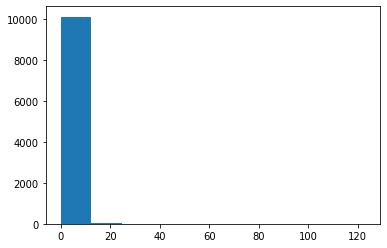

[0.00190021 0.00363504 0.00439666 ... 0.00225894 0.00314266 0.00355526]


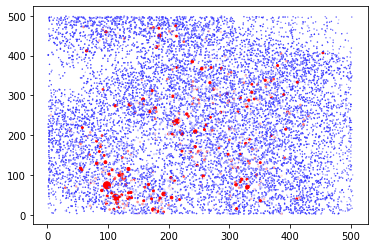

In [22]:
i=5
css=nmf.components_
comp= css[i,:]
plt.hist(comp)
plt.show()
comp= comp/np.max(np.abs(comp))
lam = np.abs(comp)
print(lam)
plt.scatter(xpos, ypos, s = 50*lam, c = css[i,:], cmap='bwr',vmin=0,vmax=8)